In [1]:
%config InlineBackend.figure_format = 'retina'


In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='.*messagestream.*')
warnings.filterwarnings('ignore', category=UserWarning, module='keras.engine.training')

# Standard libraries
import os
import pickle
import importlib.machinery
from tqdm import tqdm

# Data handling and numerical operations
import numpy as np
import pandas as pd

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
import joblib
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Visualization
import matplotlib.pyplot as plt

# Set logging level for TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import your custom functions
functions = importlib.machinery.SourceFileLoader('module_name', './custom_functions.py').load_module()


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


data shape: (1363, 15133)


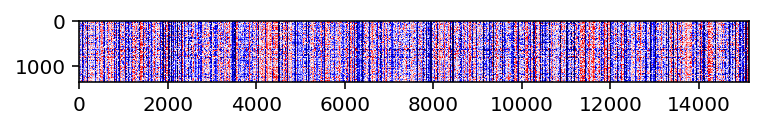

In [3]:
# load and split original data (split so uploadable to Github)
# GSE96058 = functions.data_load('./data/GSE96058.csv')
# functions.split_csv('./data/GSE96058.csv', './data/GSE96058')

# merge and load data train test split
GSE96058 = functions.merge_load_csv('./data/GSE96058')
plt.imshow(GSE96058, cmap='seismic', interpolation='nearest')

x_train shape: (1090, 15132)    y_train shape: (1090,)
x_test shape : (273, 15132)    y_test shape: (273,)


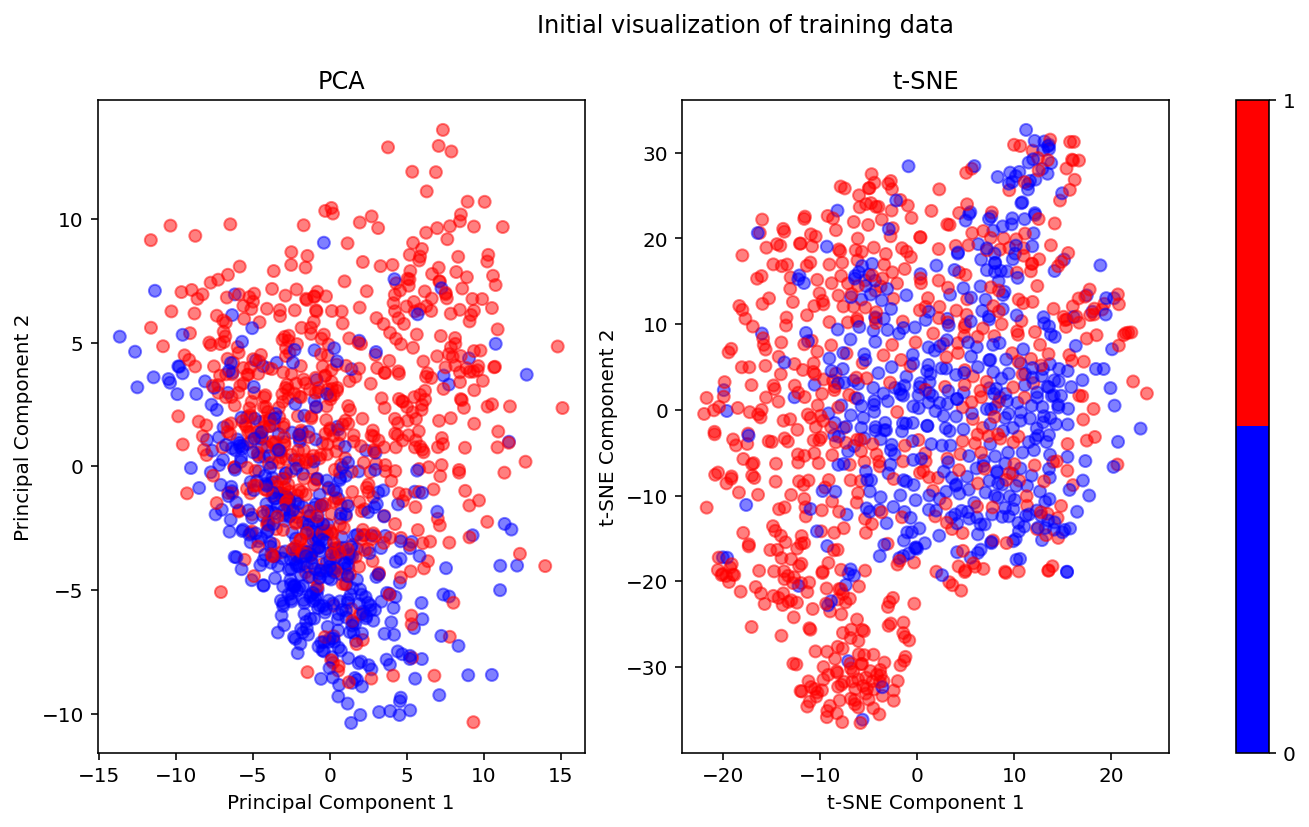

In [4]:
# train/test split (80/20 default)
x_train, x_test, y_train, y_test = functions.train_test_splitting(GSE96058)

# visualize PCA and t-SNE of training data
functions.visualize_training_data(x_train, y_train)

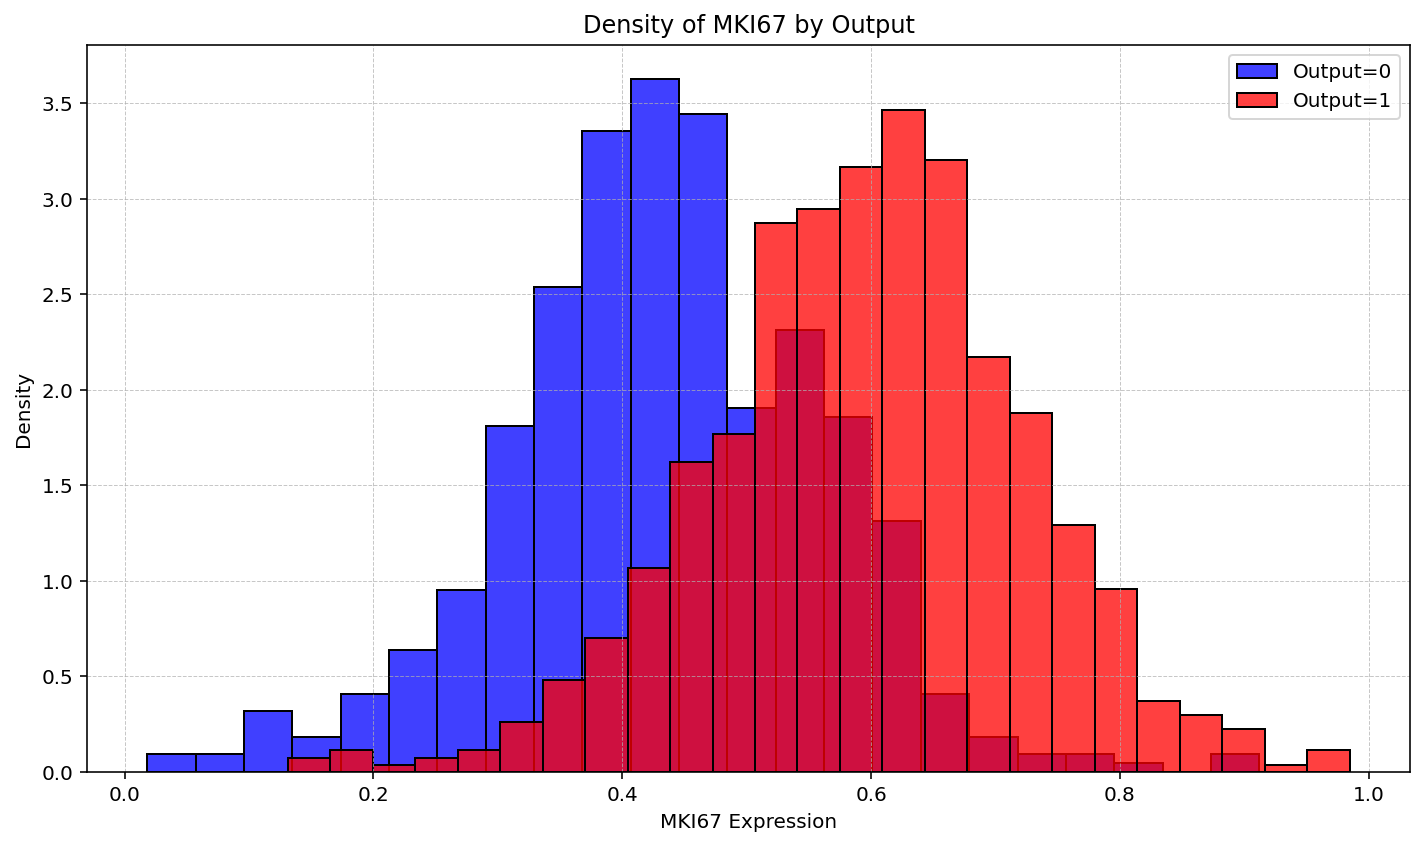

In [5]:
# Explore distribution of any gene with KI-67 status
functions.plot_feature_density(GSE96058, 'MKI67')


--- kernel pca ---


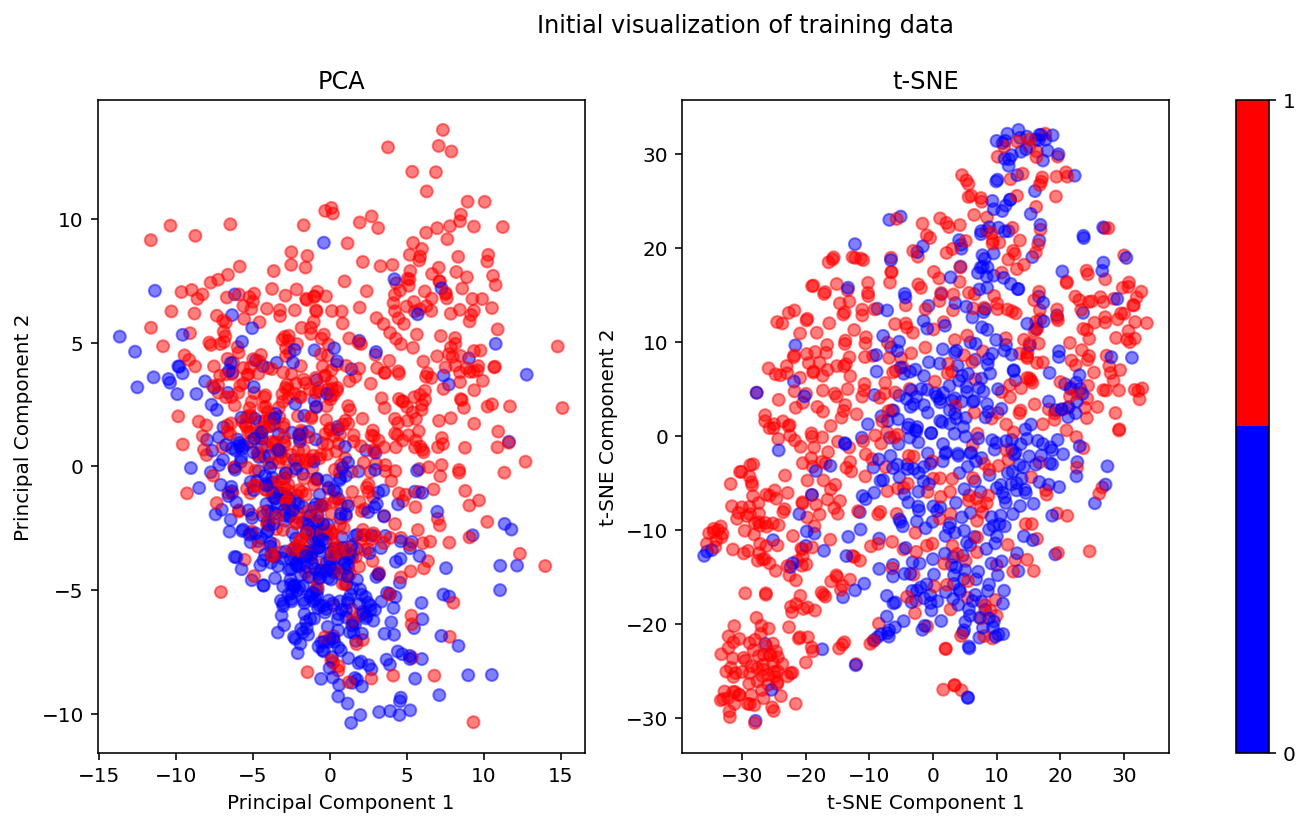

In [6]:
k = 100
# 'PCA', 'FA', 'LDA', 'SVD', 'KernelPCA', 'SparsePCA', 'Isomap', 'ICA', 'NMF'
print("--- kernel pca ---")
x_train_reduced, x_test_reduced, kernelpca_reducer = functions.apply_dimensionality_reduction(x_train, x_test, 'KernelPCA', k)
functions.visualize_training_data(x_train_reduced, y_train)



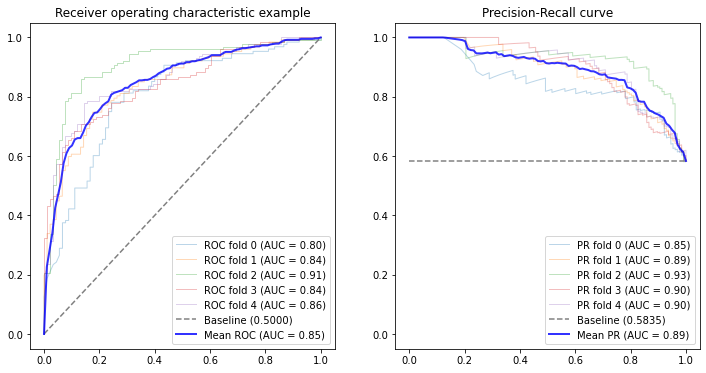

Average F1 score: 0.81
Average Accuracy: 0.79
Average AUROC: 0.85
Average AUPRC: 0.89


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers


# Creating MLP model
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='tanh', input_dim=input_dim))
    model.add(layers.Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(Dense(16, activation='tanh'))
    model.add(layers.Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])
    return model


input_dim = x_train_reduced.shape[1]

# Wrapping the Keras model with KerasClassifier
mlp_model = KerasClassifier(build_fn=lambda: create_mlp_model(input_dim), epochs=100, batch_size=32, verbose=0)

# Using the custom evaluation function
folds = 5
functions.model_evaluation(mlp_model, x_train_reduced, y_train, folds)

# fit MLP model on training data
mlp_model.fit(x_train_reduced, y_train)


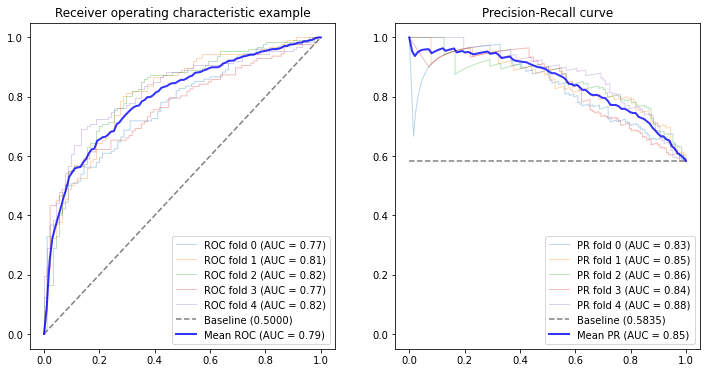

Average F1 score: 0.76
Average Accuracy: 0.72
Average AUROC: 0.80
Average AUPRC: 0.85


In [22]:
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Creating CNN Model
def create_cnn_model():
    # Find the square root of the feature size (rounded up), which will be our new width and height
    sqrt_p = math.ceil(math.sqrt(k))

    # Now let's define the model
    model = Sequential()
    model.add(Reshape((sqrt_p, sqrt_p, 1), input_shape=(k,)))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))    
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['AUC'])

    return model

# One-Hot Encoding
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)

# Wrapping the Keras model with KerasClassifier
cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=100, batch_size=32, verbose=0)

# Using the custom evaluation function
folds = 5
functions.model_evaluation(cnn_model, x_train_reduced, y_train, folds)

# fit CNN model on training data
cnn_model.fit(x_train_reduced, y_train)

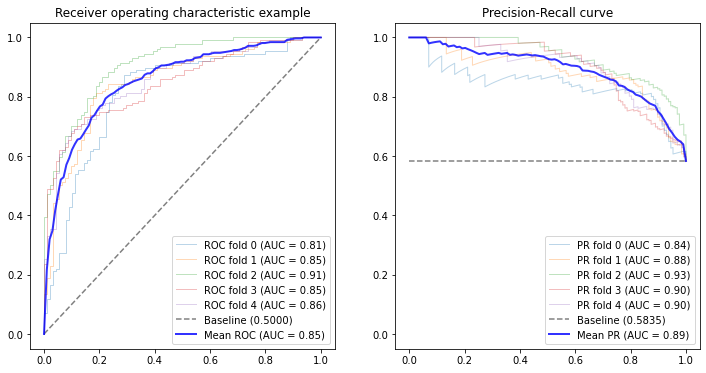

Average F1 score: 0.81
Average Accuracy: 0.78
Average AUROC: 0.86
Average AUPRC: 0.89


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Creating LOG Model
def create_logistic_model(input_dim):
    model = Sequential()
    # Just one output neuron with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid', input_dim=input_dim))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])
    return model

input_dim = x_train_reduced.shape[1]

# Wrapping the Keras model with KerasClassifier
log_model = KerasClassifier(build_fn=lambda: create_logistic_model(input_dim), epochs=100, batch_size=32, verbose=0)

# Using the custom evaluation function
folds = 5
functions.model_evaluation(log_model, x_train_reduced, y_train, folds)

# fit LOG model on training data
log_model.fit(x_train_reduced, y_train)


In [8]:
# Saving Model - 
# Note - this will rewrite models with same name
# functions.save_keras_model(mlp_model, './results/models/mlp_model.h5')
# functions.save_keras_model(cnn_model, './results/models/cnn_model.h5')
# functions.save_keras_model(log_model, './results/models/log_model.h5')


In [7]:
# Call the function with your model path
print('------------------------------ LOG MODEL ------------------------------')
functions.print_model_summary('./results/models/log_model.h5')
print('\n\n\n------------------------------ MLP MODEL ------------------------------')
functions.print_model_summary('./results/models/mlp_model.h5')
print('\n\n\n------------------------------ CNN MODEL ------------------------------')
functions.print_model_summary('./results/models/cnn_model.h5')



------------------------------ LOG MODEL ------------------------------
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 1)                 101       
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________



------------------------------ MLP MODEL ------------------------------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
__________________

100%|███████████████████████████████████| 15132/15132 [8:32:16<00:00,  2.03s/it]


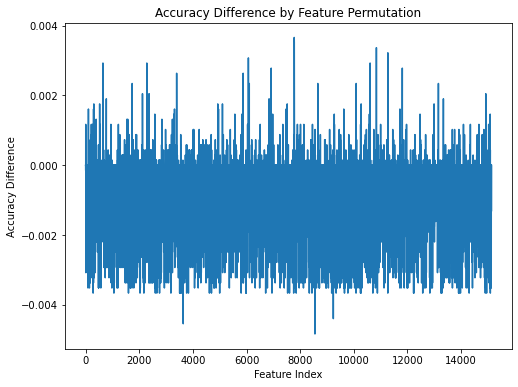

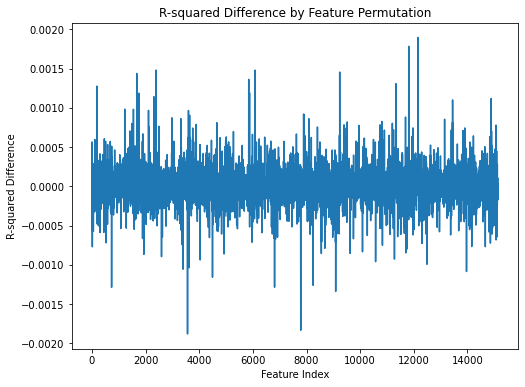

In [10]:
# # Generate Model Feature Importances (LOG)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/log_model.h5', 
#                                  './results/feature_importance/log_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/log_model.h5', 
#                                  './results/feature_importance/log_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/log_model.h5', 
#                                  './results/feature_importance/log_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/log_model.h5', 
#                                  './results/feature_importance/log_model', 25)


100%|███████████████████████████████████| 15132/15132 [8:27:59<00:00,  2.01s/it]


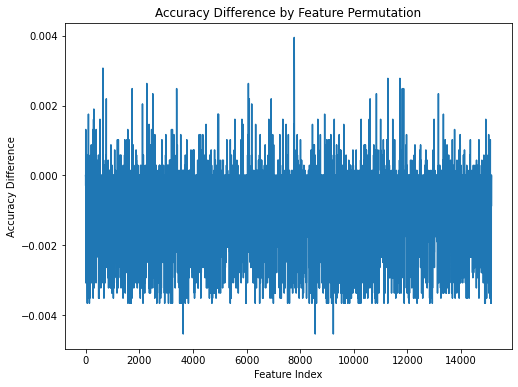

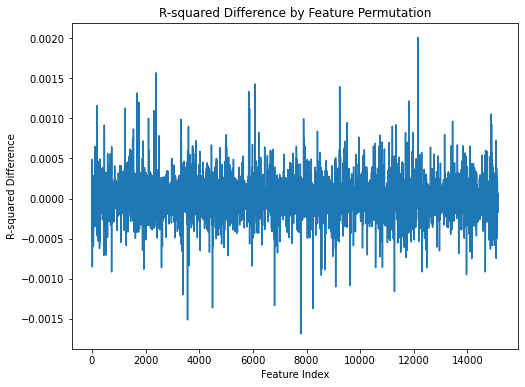

In [11]:
# # Generate Model Feature Importances (MLP)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/mlp_model.h5', 
#                                  './results/feature_importance/mlp_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/mlp_model.h5', 
#                                  './results/feature_importance/mlp_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/mlp_model.h5', 
#                                  './results/feature_importance/mlp_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/mlp_model.h5', 
#                                  './results/feature_importance/mlp_model', 25)


100%|███████████████████████████████████| 15132/15132 [9:55:18<00:00,  2.36s/it]


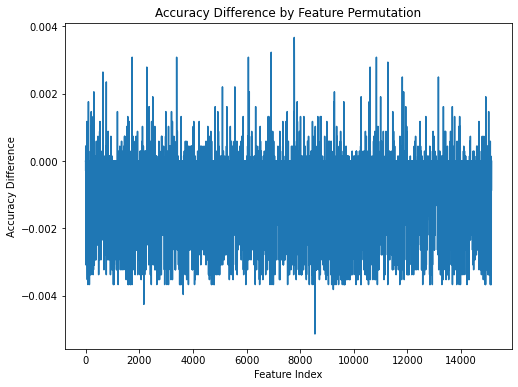

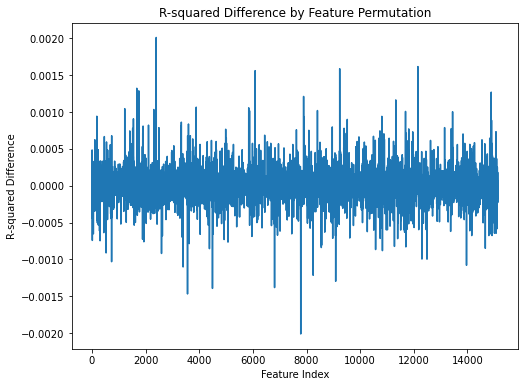

In [12]:
# # Generate Model Feature Importances (CNN)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/cnn_model.h5', 
#                                  './results/feature_importance/cnn_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/cnn_model.h5', 
#                                  './results/feature_importance/cnn_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/cnn_model.h5', 
#                                  './results/feature_importance/cnn_model', 25)
# functions.get_feature_importance(x_test, y_test, kernelpca_reducer, 
#                                  './results/models/cnn_model.h5', 
#                                  './results/feature_importance/cnn_model', 25)


set()
Expected total overlap (any two of three groups): 1.98
Probability of observing at least 36 overlaps: 0.0000000


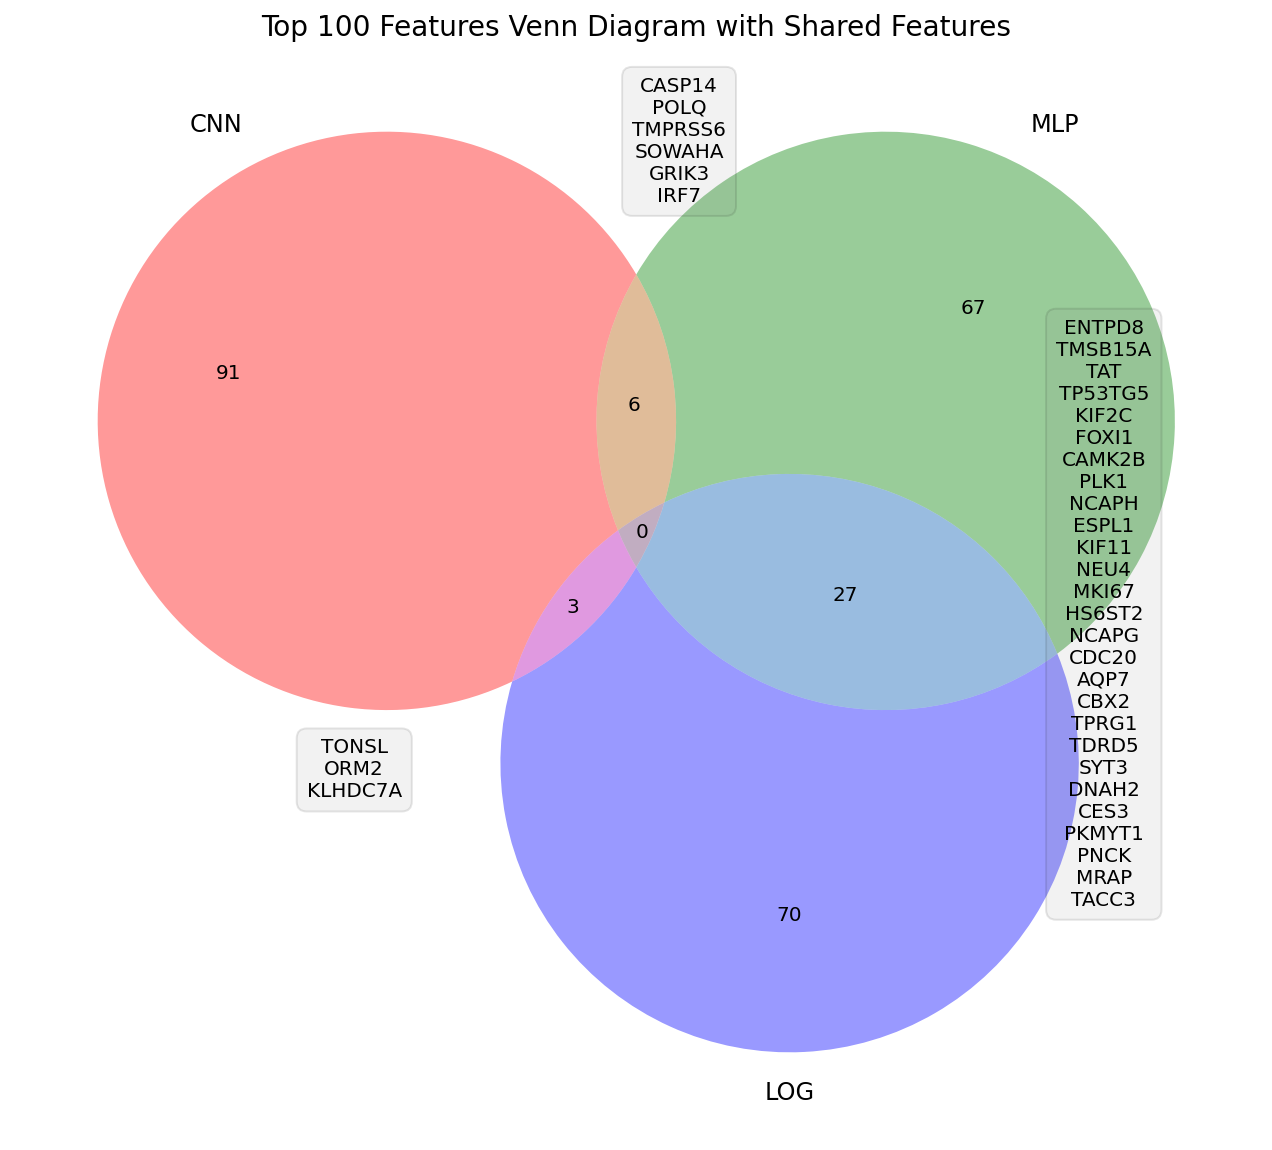

In [20]:
mlp_importances = functions.fetch_importances(GSE96058, './results/feature_importance/mlp_model')
cnn_importances = functions.fetch_importances(GSE96058, './results/feature_importance/cnn_model')
log_importances = functions.fetch_importances(GSE96058, './results/feature_importance/log_model')


functions.plot_top_features_venn([cnn_importances, mlp_importances, log_importances], top_n=100, 
                                 total_features= 15133, show_annotations = True)